[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/broadinstitute/g2papi/blob/main/examples/ex3_large_scale_variant_characterization/large_scale_variant_characterization.ipynb)

In [74]:
# @title Large Scale Variant Characterization

# @markdown ## Download ClinVar variants

! wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz

! gunzip variant_summary.txt.gz

In [100]:
# @markdown ## Collect Gene Data
gene_list = [
    ("BRCA1", "P38398"),
    ("PTEN", "P60484"),
    ("KRAS", "P01116"),
    ("TP53", "P04637")
]

# @markdown ### Load List of Genes

import g2papi
import pandas as pd

chaperones = pd.read_csv("query results.csv")
chaperones.head()

,id,UniProt,Symbol,Name,Target Development Level,IDG Family,Novelty
0,192,P61604,HSPE1,"10 kDa heat shock protein, mitochondrial",Tbio,Other,0.000744
1,908,Q58FF3,HSP90B2P,Putative endoplasmin-like protein,Tdark,Other,NaN
2,909,P14625,HSP90B1,Endoplasmin,Tchem,Other,0.001359
3,1824,Q9HAV7,GRPEL1,"GrpE protein homolog 1, mitochondrial",Tbio,Other,0.001853
4,1825,Q8TAA5,GRPEL2,"GrpE protein homolog 2, mitochondrial",Tbio,Other,0.526602


In [ ]:
# @markdown ### Get Protein Features for the G2P portal Protein Feature API

from tqdm.notebook import tqdm

protein_features_by_gene = {}

for entry in tqdm(chaperones.to_dict(orient="records")):
    gene = entry["Symbol"]
    uniprot_id = entry["UniProt"]
    protein_features = g2papi.get_protein_features(gene, uniprot_id)

    protein_features_by_gene[gene] = protein_features


  0%|          | 0/110 [00:00<?, ?it/s]

In [103]:
# @markdown ## Normalize Protein Features

# @markdown ### Define Functions to Normalize Protein Features

# @markdown For Categorical Features, we will use one-hot encoding, and for quantitative features, we will scale the values.

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import re


def is_uniprot(col):
    return "(UniProt)" in col

def is_ptm(col):
    return col in [
        "Acetylation",
        "Disease-associated PTMs",
        "Methylation",
        "O-GalNAc",
        "O-GlcNAc",
        "Phosphorylation",
        "SNP-associated PTMs",
        "Regulatory sites",
        "Substrate genes",
        "SUMOylation",
        "Ubiquitination",
    ]

def is_pocket(col):
    return col == "Pocket number (fpocket)*"

def is_ppi(col):
    is_pdb_ppi = ("bond (PDB)" in col) or ("interaction (PDB)" in col) \
       or ("bridge (PDB)" in col)
    is_af2_ppi = ("bond (AlphaFold2)" in col) or ("interaction (AlphaFold2)" in col) \
       or ("bridge (AlphaFold2)" in col)
    
    return is_pdb_ppi or is_af2_ppi

def is_mave_outlier(col):
    return bool(re.match(r'^\d{7,9}-[a-z0-9]-\d{1,3} outliers⁺⁺$', col))


def is_categorical(col):
    categorical_cols = [
        "Amino acid residues",
        "Amino acid properties",
        "Secondary structure (PDBe/SIFTS)",
        "Secondary structure (DSSP 3-state)*",
        "Secondary structure (DSSP 9-state)*"
    ]

    return is_uniprot(col) or col in categorical_cols \
       or is_ptm(col) or is_ppi(col) or is_mave_outlier(col) \
       or is_pocket(col)

def non_nan_always_1(col):

    matches = is_uniprot(col) or is_ptm(col) \
        or is_ppi(col) or is_mave_outlier(col) \
        or is_pocket(col)
    #print(col, matches)
    return matches


# for all columns starting with amino acid columns, normalize quantitative columns and 
# use one hot encoding for categorical variables

def normalize_gene_data(gene_data):
    # Make a copy to avoid modifying the original data
    df = gene_data.copy()
    
    # Excluding chain and AA which are unique identifiers
    amino_acid_cols = [col for col in df.columns if col not in ['residueId', 'AA']]
    
    # Process each column
    normalized_df = df[['residueId', 'AA']].copy()

    normalized_cols = []
    
    for col in amino_acid_cols:
        try:
            # Check if column is numeric
            if not is_categorical(col):
                # Normalize numeric columns using StandardScaler
                # First handle any NaN value

                col_data = df[col].fillna(df[col].mean())
                # if col_data is all 0, no need to normalize
                if col_data.sum() != 0 and col_data.nunique() > 1:
                    scaler = StandardScaler()
                    col_data = scaler.fit_transform(col_data.values.reshape(-1, 1))

                normalized_cols.append(pd.DataFrame(
                    col_data,
                    columns=[f"{col}_normalized"],
                    index=df.index
                ))
            else:
                #print(col)
                # For categorical columns, apply one-hot encoding
                if non_nan_always_1(col):
                    col_data = df[col].notna().astype(int)

                    normalized_cols.append(pd.DataFrame(
                        col_data,
                        columns=[col],
                        index=df.index
                    ))
                else:
                    #print(col, 2)

                    # First handle any NaN values
                    #col_data = df[col].fillna('Unknown')
                    col_data = df[col]
                    
                    # Apply one-hot encoding
                    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                    encoded = encoder.fit_transform(col_data.values.reshape(-1, 1))
                    
                    # Create new columns for each category
                    categories = encoder.categories_[0]

                    normalized_cols.append(pd.DataFrame(
                        encoded,
                        columns=[f"{col}_{category}" for category in categories],
                        index=df.index
                    ))
        except:
            print(f"Failed process for col {col}")
    
    all_dfs = [normalized_df] + normalized_cols
    normalized_df = pd.concat(all_dfs, axis=1)
    
    return normalized_df



In [105]:
# @markdown ### Normalize Protein Features for Each Gene

normalized_data = []

for entry in tqdm(chaperones.to_dict(orient="records")):
    gene = entry["Symbol"]
    uniprot_id = entry["UniProt"]
    protein_features = protein_features_by_gene[gene]
    normalized_df = normalize_gene_data(protein_features)
    normalized_df["gene"] = gene # add a gene col
    normalized_data.append(normalized_df)


  0%|          | 0/110 [00:00<?, ?it/s]

/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_coun

Failed process for col Druggability score (fpocket)*
Failed process for col Druggability score (fpocket)*
Failed process for col Druggability score (fpocket)*


/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jsafer/.myenvs/jupyter_default/lib/python3.10/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_coun

In [106]:
# @markdown ## Now make a simple model to predict breaking/not breaking HO hydrogen bond

# @markdown ### Concatenate all normalized data and drop MAVE columns which are specific to a single gene

final_df = pd.concat(normalized_data)


to_drop = []
for col in final_df.columns:
    if is_mave_outlier(col) or "avg_normalized" in col:
        to_drop.append(col)


final_df = final_df.drop(columns=to_drop)


final_df = final_df.fillna(0)



In [111]:
# @markdown ## Load ClinVar Pathogenic Missense Variants for the genes
clinvar_variants = pd.read_csv("variant_summary.txt", sep="\t")

clinvar_variants.head()

/var/folders/d8/p2r3zx7x1_920ng69wrnpjsc0000gq/T/ipykernel_56946/57004287.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_variants = pd.read_csv("variant_summary.txt", sep="\t")


,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,AlternateAlleleVCF,SomaticClinicalImpact,SomaticClinicalImpactLastEvaluated,ReviewStatusClinicalImpact,Oncogenicity,OncogenicityLastEvaluated,ReviewStatusOncogenicity,SCVsForAggregateGermlineClassification,SCVsForAggregateSomaticClinicalImpact,SCVsForAggregateOncogenicityClassification
0,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...,9907,AP5Z1,HGNC:22197,Pathogenic/Likely pathogenic,1,"Dec 17, 2024",397704705,...,TGCTGTAAACTGTAACTGTAAA,-,-,-,-,-,-,SCV001451119|SCV005622007|SCV005909190,-,-
1,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...,9907,AP5Z1,HGNC:22197,Pathogenic/Likely pathogenic,1,"Dec 17, 2024",397704705,...,TGCTGTAAACTGTAACTGTAAA,-,-,-,-,-,-,SCV001451119|SCV005622007|SCV005909190,-,-
2,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),9907,AP5Z1,HGNC:22197,Pathogenic,1,"Jun 29, 2010",397704709,...,G,-,-,-,-,-,-,SCV000020156,-,-
3,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),9907,AP5Z1,HGNC:22197,Pathogenic,1,"Jun 29, 2010",397704709,...,G,-,-,-,-,-,-,SCV000020156,-,-
4,15043,single nucleotide variant,NM_014630.3(ZNF592):c.3136G>A (p.Gly1046Arg),9640,ZNF592,HGNC:28986,Uncertain significance,0,"Jun 29, 2015",150829393,...,A,-,-,-,-,-,-,SCV000020157,-,-


In [123]:
pathogenic_variants = clinvar_variants[clinvar_variants["ClinSigSimple"] == 1]

pathogenic_labels = ["Pathogenic", "Likely pathogenic", "Pathogenic/Likely pathogenic"]

pathogenic_variants = pathogenic_variants[pathogenic_variants["ClinicalSignificance"].isin(pathogenic_labels)]
pathogenic_variants.head()

,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,AlternateAlleleVCF,SomaticClinicalImpact,SomaticClinicalImpactLastEvaluated,ReviewStatusClinicalImpact,Oncogenicity,OncogenicityLastEvaluated,ReviewStatusOncogenicity,SCVsForAggregateGermlineClassification,SCVsForAggregateSomaticClinicalImpact,SCVsForAggregateOncogenicityClassification
0,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...,9907,AP5Z1,HGNC:22197,Pathogenic/Likely pathogenic,1,"Dec 17, 2024",397704705,...,TGCTGTAAACTGTAACTGTAAA,-,-,-,-,-,-,SCV001451119|SCV005622007|SCV005909190,-,-
1,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...,9907,AP5Z1,HGNC:22197,Pathogenic/Likely pathogenic,1,"Dec 17, 2024",397704705,...,TGCTGTAAACTGTAACTGTAAA,-,-,-,-,-,-,SCV001451119|SCV005622007|SCV005909190,-,-
2,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),9907,AP5Z1,HGNC:22197,Pathogenic,1,"Jun 29, 2010",397704709,...,G,-,-,-,-,-,-,SCV000020156,-,-
3,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),9907,AP5Z1,HGNC:22197,Pathogenic,1,"Jun 29, 2010",397704709,...,G,-,-,-,-,-,-,SCV000020156,-,-
6,15044,single nucleotide variant,NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter),55572,FOXRED1,HGNC:26927,Pathogenic,1,"Mar 12, 2024",267606829,...,T,-,-,-,-,-,-,SCV000680696|SCV001363290|SCV002793147|SCV0029...,-,-


In [124]:
columns = pathogenic_variants.columns

# Assembly = GRCh38
# Type = single nucleotide variant
print(pathogenic_variants.shape)
pathogenic_snvs = pathogenic_variants[pathogenic_variants["Type"] == "single nucleotide variant"]
pathogenic_snvs = pathogenic_snvs[pathogenic_snvs["Assembly"] == "GRCh38"]
print(pathogenic_snvs.shape)

# and does not end with "Ter)"
pathogenic_snvs = pathogenic_snvs[~pathogenic_snvs["Name"].str.endswith("Ter)")]
print(pathogenic_snvs.shape)

pathogenic_snvs.head()

(653663, 43)
(170250, 43)
(106239, 43)


,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,AlternateAlleleVCF,SomaticClinicalImpact,SomaticClinicalImpactLastEvaluated,ReviewStatusClinicalImpact,Oncogenicity,OncogenicityLastEvaluated,ReviewStatusOncogenicity,SCVsForAggregateGermlineClassification,SCVsForAggregateSomaticClinicalImpact,SCVsForAggregateOncogenicityClassification
9,15045,single nucleotide variant,NM_017547.4(FOXRED1):c.1289A>G (p.Asn430Ser),55572,FOXRED1,HGNC:26927,Likely pathogenic,1,"Jun 06, 2024",267606830,...,G,-,-,-,-,-,-,SCV005680614,-,-
31,15057,single nucleotide variant,NM_000410.4(HFE):c.989G>T (p.Arg330Met),3077,HFE,HGNC:4886,Pathogenic,1,"Aug 01, 1999",111033558,...,T,-,-,-,-,-,-,SCV000020178,-,-
33,15058,single nucleotide variant,NM_000410.4(HFE):c.848A>C (p.Gln283Pro),3077,HFE,HGNC:4886,Pathogenic/Likely pathogenic,1,"Mar 05, 2025",111033563,...,C,-,-,-,-,-,-,SCV001214178|SCV004028688|SCV004702708|SCV0058...,-,-
35,15059,single nucleotide variant,NM_020779.4(WDR35):c.25-2A>G,57539,WDR35,HGNC:29250,Pathogenic,1,"Sep 10, 2010",397515534,...,C,-,-,-,-,-,-,SCV000020180,-,-
37,15060,single nucleotide variant,NM_020779.4(WDR35):c.1844A>G (p.Glu615Gly),57539,WDR35,HGNC:29250,Pathogenic,1,"Sep 10, 2010",267607174,...,C,-,-,-,-,-,-,SCV000020181,-,-


In [125]:
# Filter for GeneSymbol matching the chaperones dataframe
pathogenic_snvs = pathogenic_snvs[pathogenic_snvs["GeneSymbol"].isin(chaperones["Symbol"])]
print(pathogenic_snvs.shape)

pathogenic_snvs.head()



(177, 43)


,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,AlternateAlleleVCF,SomaticClinicalImpact,SomaticClinicalImpactLastEvaluated,ReviewStatusClinicalImpact,Oncogenicity,OncogenicityLastEvaluated,ReviewStatusOncogenicity,SCVsForAggregateGermlineClassification,SCVsForAggregateSomaticClinicalImpact,SCVsForAggregateOncogenicityClassification
4015,17208,single nucleotide variant,NM_007214.5(SEC63):c.733+1G>A,11231,SEC63,HGNC:21082,Pathogenic,1,"Dec 23, 2021",886041028,...,T,-,-,-,-,-,-,SCV002766802|SCV002810036,-,-
12829,22064,single nucleotide variant,NM_003085.5(SNCB):c.208G>A (p.Val70Met),6620,SNCB,HGNC:11140,Pathogenic,1,"Sep 14, 2004",104893936,...,T,-,-,-,-,-,-,SCV000027640,-,-
13684,22528,single nucleotide variant,NM_002775.5(HTRA1):c.889G>A (p.Val297Met),5654,HTRA1,HGNC:9476,Pathogenic,1,"Apr 23, 2009",113993969,...,A,-,-,-,-,-,-,SCV000028123,-,-
13686,22529,single nucleotide variant,NM_002775.5(HTRA1):c.754G>A (p.Ala252Thr),5654,HTRA1,HGNC:9476,Pathogenic,1,"Apr 23, 2009",113993968,...,A,-,-,-,-,-,-,SCV000028124,-,-
15369,23440,single nucleotide variant,NM_004082.5(DCTN1):c.175G>A (p.Gly59Ser),1639,DCTN1,HGNC:2711,Pathogenic,1,"Oct 27, 2020",121909342,...,T,-,-,-,-,-,-,SCV000766182,-,-


In [147]:
variants = []

for variant in pathogenic_snvs.to_dict(orient="records"):
    gene = variant["GeneSymbol"]
    impact = variant["Name"].split(":")[1]
    has_protein_position = "p." in variant["Name"]
    if not has_protein_position:
        continue
    protein_change = variant["Name"].split("p.")[1].split(")")[0]
    protein_position = int(protein_change[3:][:-3])
    transcript = variant["Name"].split("(")[0]
    variants.append({
        "gene": gene,
        "impact": impact,
        "protein_position": protein_position,
        "transcript": transcript
    })

variants_df = pd.DataFrame(variants)
print(variants_df.shape)

# drop duplicates (same protein position and transcript)
variants_df = variants_df.drop_duplicates(subset=["gene", "protein_position", "transcript"])
print(variants_df.shape)

variants_df.head()


(108, 4)
(96, 4)


,gene,impact,protein_position,transcript
0,SNCB,c.208G>A (p.Val70Met),70,NM_003085.5
1,HTRA1,c.889G>A (p.Val297Met),297,NM_002775.5
2,HTRA1,c.754G>A (p.Ala252Thr),252,NM_002775.5
3,DCTN1,c.175G>A (p.Gly59Ser),59,NM_004082.5
4,DCTN1,c.221A>C (p.Gln74Pro),74,NM_004082.5


In [150]:
variant_genes = variants_df["gene"].unique()

canonical_isoform_variants = []
for gene in variant_genes:
    uniprot_id = chaperones[chaperones["Symbol"] == gene]["UniProt"].values[0]
    transcript_map = g2papi.get_gene_transcript_protein_isoform_structure(gene, uniprot_id)

    #print(gene)

    transcripts = variants_df[variants_df["gene"] == gene]["transcript"].values
    transcripts = [t.split(".")[0] for t in transcripts]
    #print(transcripts)
    transcript = transcripts[0]

    refseq_col = "RefSeq mRNA Id"
    transcript_map[refseq_col] = transcript_map[refseq_col].str.split("(").str[0]
    refseq_match = transcript_map[transcript_map[refseq_col] == transcript]
    #print(refseq_match.shape)
    #print(refseq_match.head())

    uniprot_isoform = refseq_match["UniProt Isoform"].values[0]
    is_canonical = uniprot_isoform.endswith("(*)")
    #print(is_canonical)
    if is_canonical:
        canonical_isoform_variants.append(variants_df[variants_df["gene"] == gene])

canonical_isoform_variants_df = pd.concat(canonical_isoform_variants)
print(canonical_isoform_variants_df.shape)
canonical_isoform_variants_df.head()

genes_with_canonical_isoform_variants = canonical_isoform_variants_df["gene"].unique()
print(f"There are {len(genes_with_canonical_isoform_variants)} genes with canonical isoform variants")

def is_pathogenic_variant(gene, protein_position):
    return canonical_isoform_variants_df[(canonical_isoform_variants_df["gene"] == gene) & (canonical_isoform_variants_df["protein_position"] == protein_position)].shape[0] > 0


(91, 4)
There are 18 genes with canonical isoform variants


In [151]:
# @markdown ## Construct Model Labels and Features

# @markdown ### Filter for genes with ClinVar Pathogenic Variants

final_df = final_df[final_df["gene"].isin(genes_with_canonical_isoform_variants)]

# @markdown ### Get Hydrogen Bond Columns as Labels
def is_hydrogen_bond(col):
    return "Hydrogen bond" in col

hb_cols = [col for col in final_df.columns if is_hydrogen_bond(col)]

final_df["pathogenic"] = final_df.apply(lambda row: is_pathogenic_variant(row["gene"], row["residueId"]), axis=1)
final_df_pathogenic = final_df[final_df["pathogenic"]]
final_df_non_pathogenic = final_df[~final_df["pathogenic"]]
# model label: if there is a hydrogen bond present
y = (final_df[hb_cols].sum(axis=1) > 0).astype(int)
y_pathogenic = (final_df_pathogenic[hb_cols].sum(axis=1) > 0).astype(int)
y_non_pathogenic = (final_df_non_pathogenic[hb_cols].sum(axis=1) > 0).astype(int)

# @markdown ### Get Remaining Columns as Features
cols_to_skip = hb_cols + ["residueId", "AA", "gene", "pathogenic"]
X = final_df.drop(columns=cols_to_skip)
X_pathogenic = final_df_pathogenic.drop(columns=cols_to_skip)
X_non_pathogenic = final_df_non_pathogenic.drop(columns=cols_to_skip)

In [152]:
# @markdown ## Split Data into Training and Testing Sets

test_percentage = 0.2 # @param {type:"number"}

from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_non_pathogenic, y_non_pathogenic, test_size=test_percentage, random_state=42, stratify=y_non_pathogenic
)

# Print dataset sizes
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Positive labels (training): {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"Positive labels (test): {y_test.sum()} ({y_test.mean()*100:.2f}%)")

print(f"Pathogenic set: {X_pathogenic.shape[0]} samples")
print(f"Positive labels (pathogenic): {y_pathogenic.sum()} ({y_pathogenic.mean()*100:.2f}%)")

Training set: 7422 samples
Test set: 1856 samples
Positive labels (training): 5297 (71.37%)
Positive labels (test): 1324 (71.34%)
Pathogenic set: 91 samples
Positive labels (pathogenic): 76 (83.52%)


In [153]:
# @markdown ## Fit a simple Logistic Regression Model to the Training Data

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Initialize a logistic regression model
# You can adjust regularization strength with C parameter (smaller C = stronger regularization)
model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)

# @markdown ## Evaluate the Model on the Test Set

# Make predictions on test data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class

# Make predictions on pathogenic data
pathogenic_pred = model.predict(X_pathogenic)
pathogenic_pred_proba = model.predict_proba(X_pathogenic)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Evaluate the model on pathogenic data
pathogenic_accuracy = accuracy_score(y_pathogenic, pathogenic_pred)
pathogenic_roc_auc = roc_auc_score(y_pathogenic, pathogenic_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"Pathogenic Accuracy: {pathogenic_accuracy:.4f}")
print(f"Pathogenic ROC AUC: {pathogenic_roc_auc:.4f}")
print("\nClassification Report on Pathogenic Data:")
print(classification_report(y_pathogenic, pathogenic_pred))

# Feature importance (coefficients)
#feature_importance = pd.DataFrame({
#    'Feature': X_train.columns,
#    'Coefficient': model.coef_[0]
#})
#feature_importance = feature_importance.sort_values('Coefficient', ascending=False)

# Display top positive and negative coefficients
#print("\nTop 10 Most Positive Features:")
#print(feature_importance.head(10))
#print("\nTop 10 Most Negative Features:")
#print(feature_importance.tail(10))


Accuracy: 0.9089
ROC AUC: 0.9543

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       532
           1       0.92      0.95      0.94      1324

    accuracy                           0.91      1856
   macro avg       0.90      0.88      0.89      1856
weighted avg       0.91      0.91      0.91      1856

Pathogenic Accuracy: 0.8901
Pathogenic ROC AUC: 0.9149

Classification Report on Pathogenic Data:
              precision    recall  f1-score   support

           0       0.73      0.53      0.62        15
           1       0.91      0.96      0.94        76

    accuracy                           0.89        91
   macro avg       0.82      0.75      0.78        91
weighted avg       0.88      0.89      0.88        91



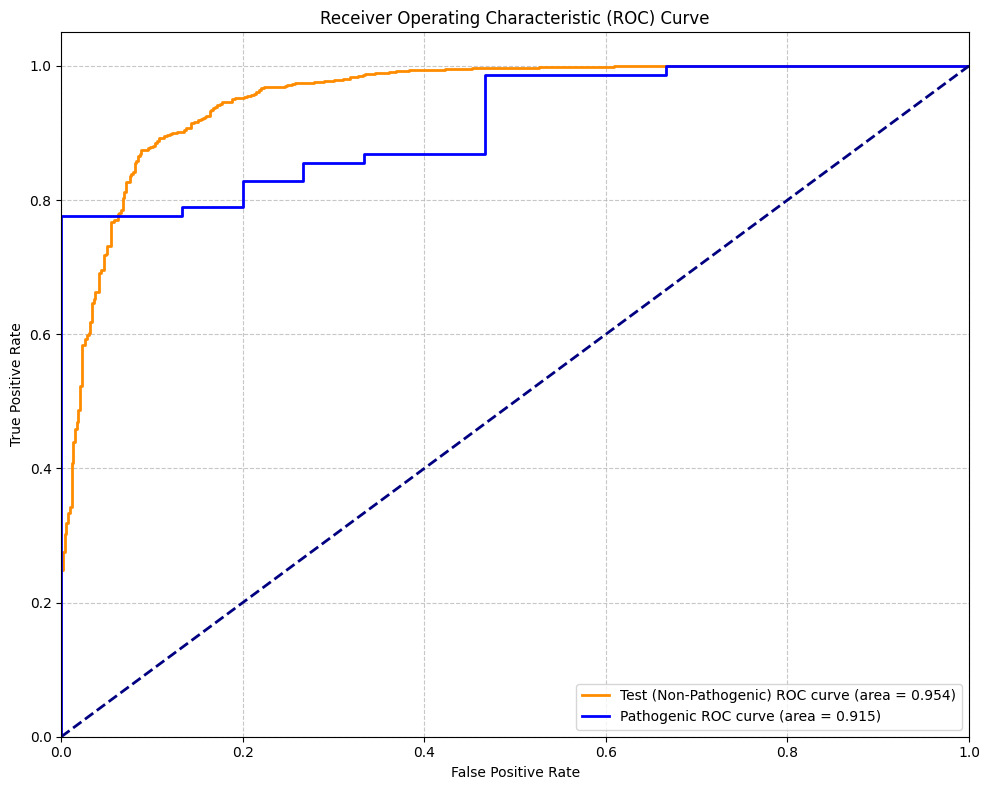

In [154]:
# @markdown ## Plot ROC Curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Calculate ROC curve points for pathogenic data
fpr_pathogenic, tpr_pathogenic, thresholds_pathogenic = roc_curve(y_pathogenic, pathogenic_pred_proba)
roc_auc_pathogenic = auc(fpr_pathogenic, tpr_pathogenic)

# Plot ROC curves for test and pathogenic data
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'Test (Non-Pathogenic) ROC curve (area = {roc_auc:.3f})')
plt.plot(fpr_pathogenic, tpr_pathogenic, color='blue', lw=2, 
         label=f'Pathogenic ROC curve (area = {roc_auc_pathogenic:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()